In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import numpy as np
import torch
import matplotlib
from matplotlib import pyplot as plt
import random
import json
import sys
sys.path.insert(0,'/home/brysongray/tractography/')
import dqn_tracker
import tracking_env
import train_dqn_tracker
from load_data import load_data
from tracking_env import Environment, density_error_change
from dqn_tracker import DQNModel
import os
from itertools import count
from tqdm import tqdm
from image import Image

In [ ]:
def show_state(env):
    state = env.get_state()[0]
    true_density_patch, _ = env.true_density.crop(env.paths[env.head_id][-1], env.radius, pad=True)
    mask = Image(env.mask, dx=[0.88,1.0,1.0])
    mask_patch, _ = mask.crop(env.paths[env.head_id][-1], env.radius, pad=True)
    I = np.array(env.img.data.to('cpu'))
    D = np.array(env.true_density.data.to('cpu'))
    O = np.array(state.to('cpu'))
    T = np.array(true_density_patch.to('cpu'))
    M = np.array(mask_patch.to('cpu'))
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(I[-1].max(axis=0))#, int(env.paths[env.head_id][-1, 0])])
    ax[1].imshow(D[0].max(axis=0))#, int(env.paths[env.head_id][-1, 0])])
    ax[2].imshow(O[0,-1].max(axis=0), alpha=0.5, cmap='hot')#, env.radius//2])
    ax[2].imshow(T[0].max(axis=0), alpha=0.5, cmap='gray')#, env.radius//2])
    ax[3].imshow(M[0].max(axis=0))
    plt.show()

def get_closest_dir(action_space, dir):
    d = np.dot(action_space, dir[:,None])
    idx = d.argmax()

    return idx

In [7]:
f = open('/home/brysongray/tractography/neuron_trx/configs/config.json')
args = json.load(f)

img_file = args["image"]
label_file = args["label"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
eps_start = args["eps_start"] if "eps_start" in args else 0.9
eps_end = args["eps_end"] if "eps_end" in args else 0.01
eps_decay = args["eps_decay"] if "eps_decay" in args else 1000
tau = args["tau"] if "tau" in args else 0.001
lr = args["lr"] if "lr" in args else 5e-4
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17
actions = np.load('/home/brysongray/tractography/neuron_trx/action_space_30_dir.npy')

img, density, mask = load_data(img_file, label_file, downsample_factor=10, binary=False)


env = Environment(img,
                    patch_radius,
                    seeds,
                    mask,
                    density,
                    actions,
                    n_seeds=n_seeds,
                    step_size=1.0,
                    step_width=step_width,
                    pixelsize=pixelsize,
                    max_len=10000,
                    alpha=alpha,
                    beta=beta,
                    friction=friction)

dqn_model = DQNModel(in_channels=4,
                        n_actions=len(actions),
                        input_size=(2*patch_radius+1),
                        lr=lr,
                        step_size=torch.tensor(step_size))

if model:
    dqn_model.load_model(torch.load(model))



/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1506:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1493:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1322:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1216:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:1118:warning

/home/brysongray/tractography/data/Cerebellar Climbing Fibers/Gold Standard Reconstructions/CF_1.swc:0:warning


In [ ]:
dqn_model.train(env,
                episodes=num_episodes,
                batch_size=batch_size,
                gamma=gamma,
                tau=tau,
                eps_start=eps_start,
                eps_end=eps_end,
                eps_decay=eps_decay,
                save_snapshots=True,
                show=False,
                name='alpha-1_beta-1.0_f-0.5_n-1')

## view mask and density

In [ ]:
fig, ax = plt.subplots(2)
ax[0].imshow(env.true_density.data[0].amax(dim=0))
ax[1].imshow(env.mask.data[0].amax(dim=0))

In [ ]:
DEVICE = 'cuda:0'

In [ ]:
env.reset()

In [ ]:
show_state(env)

In [ ]:
plt.close('all')
action = torch.tensor([0., 0.0, -1.0])
observation, reward, terminated = env.step(action, verbose=True)
print(reward)
if not terminated:
    show_state(env)
else:
    env.reset()

In [ ]:
# get the index of action_space closest to a desired step direction
action_id = get_closest_dir(env.action_space, torch.Tensor([0., 0., -1.]))
print(action_id)
print(env.action_space[action_id])

In [ ]:
output='./outputs'
episodes = 128


In [ ]:
# Train the Network
steps_done = 0
episode_durations = []
episode_returns = []
if not os.path.exists(output):
    os.makedirs(output)
# for i in tqdm(range(episodes)):
while len(dqn_model.memory) < batch_size:
    env.reset()
    state = env.get_state()[0].clone().to(dtype=torch.float32, device=DEVICE)
    ep_return = 0
    for t in count():
        action_id = dqn_model.select_action(env.action_space, state, steps_done, eps_start, eps_end, eps_decay)
        # observation, reward, terminated = env.step(env.action_space[action_id])
        action = env.action_space[action_id]

        # step
        terminated = False

        # add new position to path
        while True:
            new_position = env.paths[env.head_id][-1] + env.step_size*action
            out_of_bound = any([x >= y or x < 0 for x,y in zip(torch.round(new_position), env.img.data.shape[1:])])
            if out_of_bound:
                action = env.action_space[int(np.random.randint(len(env.action_space)))]
            else:
                break

        env.paths[env.head_id] = torch.cat((env.paths[env.head_id], new_position[None]))
        # decide if path terminates
        # out_of_mask = env.mask[tuple([int(x) for x in env.paths[env.head_id][-1]])]
        too_long = len(env.paths[env.head_id]) > env.max_len
        self_terminate = not any(action)
        terminate_path = too_long or self_terminate

        if terminate_path:
            observation = None
            reward = torch.tensor([0.], device=DEVICE)
            # remove the path from 'paths' and add it to 'ended_paths'
            env.ended_paths.append(env.paths.pop(env.head_id))
            # if that was the last path in the list, then terminate the episode
            if len(env.paths) == 0:
                terminated = True
            else:
                env.head_id = (env.head_id + 1)%len(env.paths)
        else:
            center = env.paths[env.head_id][-2]
            r = env.radius + int(np.ceil(env.step_size.max()))
            true_density_patch, _ = env.true_density.crop(center, radius=r) # patch centered at previous step position
            old_density_patch, _ = env.img.crop(center, radius=r)
            old_density_patch = old_density_patch.detach().clone()[-1][None] # need to make a copy or else this will be modified by adding a point to img
            # add_bundle_point(env.img, env.paths[env.head_id][-1], env.ball)
            segment = env.paths[env.head_id][-2:, :3]
            env.img.draw_line_segment(segment, width=1.0)
            new_density_patch, _ = env.img.crop(center, radius=r)
            new_density_patch = new_density_patch[-1][None]
            delta_density_diff = density_error_change(true_density_patch, old_density_patch, new_density_patch)
            observation = env.get_state()
            reward = env.get_reward(terminated, delta_density_diff)

            env.head_id = (env.head_id + 1)%len(env.paths)
        # end step
            
        ep_return += reward

        if terminated: # episode terminated
            next_state = None
        else:
            next_state = observation # if the streamline terminated observation is None
            if next_state is not None:
                next_state = next_state[0].clone().to(dtype=torch.float32, device=DEVICE)

        # Store the transition in memory
        dqn_model.memory.push(state, action_id, next_state, reward)

        # Perform one step of the optimization (on the policy network)
        dqn_model.optimize_model(batch_size, gamma)

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = dqn_model.target_net.state_dict()
        policy_net_state_dict = dqn_model.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
        dqn_model.target_net.load_state_dict(target_net_state_dict)

        if terminated:
            episode_durations.append(t + 1)
            episode_returns.append(ep_return)
            # if show:
            #     plot_durations(episode_durations)
            #     plot_returns(episode_returns)
            # if save_snapshots:
            #     if i%10 == 0:
            #         torch.save(env.img.data[-1].detach().clone(), os.path.join(output, f'bundle_density_ep{i}.pt'))
            #         torch.save(target_net_state_dict, os.path.join(output, f'model_state_dict_{name}.pt'))
            #         torch.save(episode_durations, os.path.join(output, 'episode_durations_{name}.pt'))
            #         torch.save(episode_returns, os.path.join(output, 'episode_returns_{name}.pt'))
            break
        # if not terminated, move to the next state
        state = env.get_state()[0].to(dtype=torch.float32, device=DEVICE) # the head of the next streamline

In [ ]:
show_state(env)

In [ ]:
dqn_model.policy_net.state_dict()['conv1.bias'].ne(dqn_model.target_net.state_dict()['conv1.bias']).sum()

In [ ]:
# Perform one step of the optimization (on the policy network)
dqn_model_params = dqn_model.policy_net.parameters().detach().clone()
print(dqn_model.policy_net.state_dict()['conv1.bias'])
dqn_model.optimize_model(batch_size, gamma)
print(dqn_model.policy_net.state_dict()['conv1.bias'])
dqn_model_params_after = dqn_model.policy_net.parameters()

for p1, p2 in zip(dqn_model_params, dqn_model_params_after):
    if p1.data.ne(p2.data).sum() > 0:
        print("Not equal")
    else:
        print('Equal')

In [ ]:
dqn_model.policy_net.state_dict()['conv1.bias']

In [ ]:
dqn_model_params_after['conv1.bias']

In [ ]:
# Soft update of the target network's weights
# θ′ ← τ θ + (1 −τ )θ′
target_net_state_dict = dqn_model.target_net.state_dict()
policy_net_state_dict = dqn_model.policy_net.state_dict()
for key in policy_net_state_dict:
    target_net_state_dict[key] = policy_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
dqn_model.target_net.load_state_dict(target_net_state_dict)

In [ ]:
if terminated:
    episode_durations.append(t + 1)
    episode_returns.append(ep_return)
    print('Terminated')

In [ ]:
config_path = "/home/brysongray/tractography/neuron_trx/configs/config.json"
f = open(config_path)
config = json.load(f)
print(type(config))

In [ ]:
train_dqn_tracker.main(config)

# View results

In [12]:
name = "alpha-1_beta-2.0_f-0.5_n-10"
output = "/home/brysongray/tractography/outputs/"
returns = torch.load(os.path.join(output, f"episode_returns_{name}.pt"))
durations = torch.load(os.path.join(output, f"episode_durations_{name}.pt"))
loss = torch.load(os.path.join(output, f"loss_{name}.pt"))
eps = torch.load(os.path.join(output, f"eps_{name}.pt"))
lr = torch.load(os.path.join(output, f"lr_{name}.pt"))

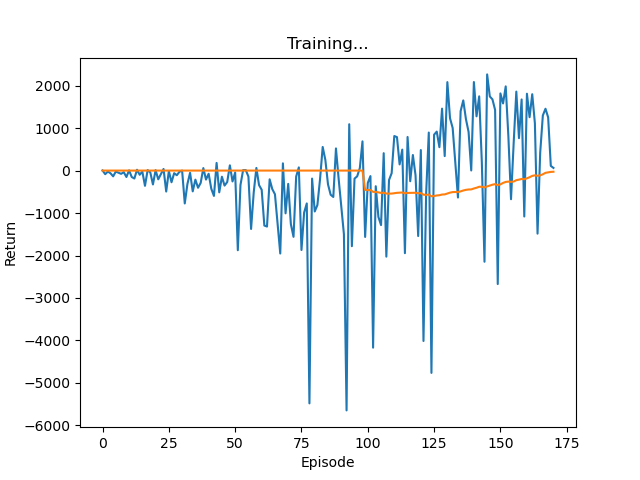

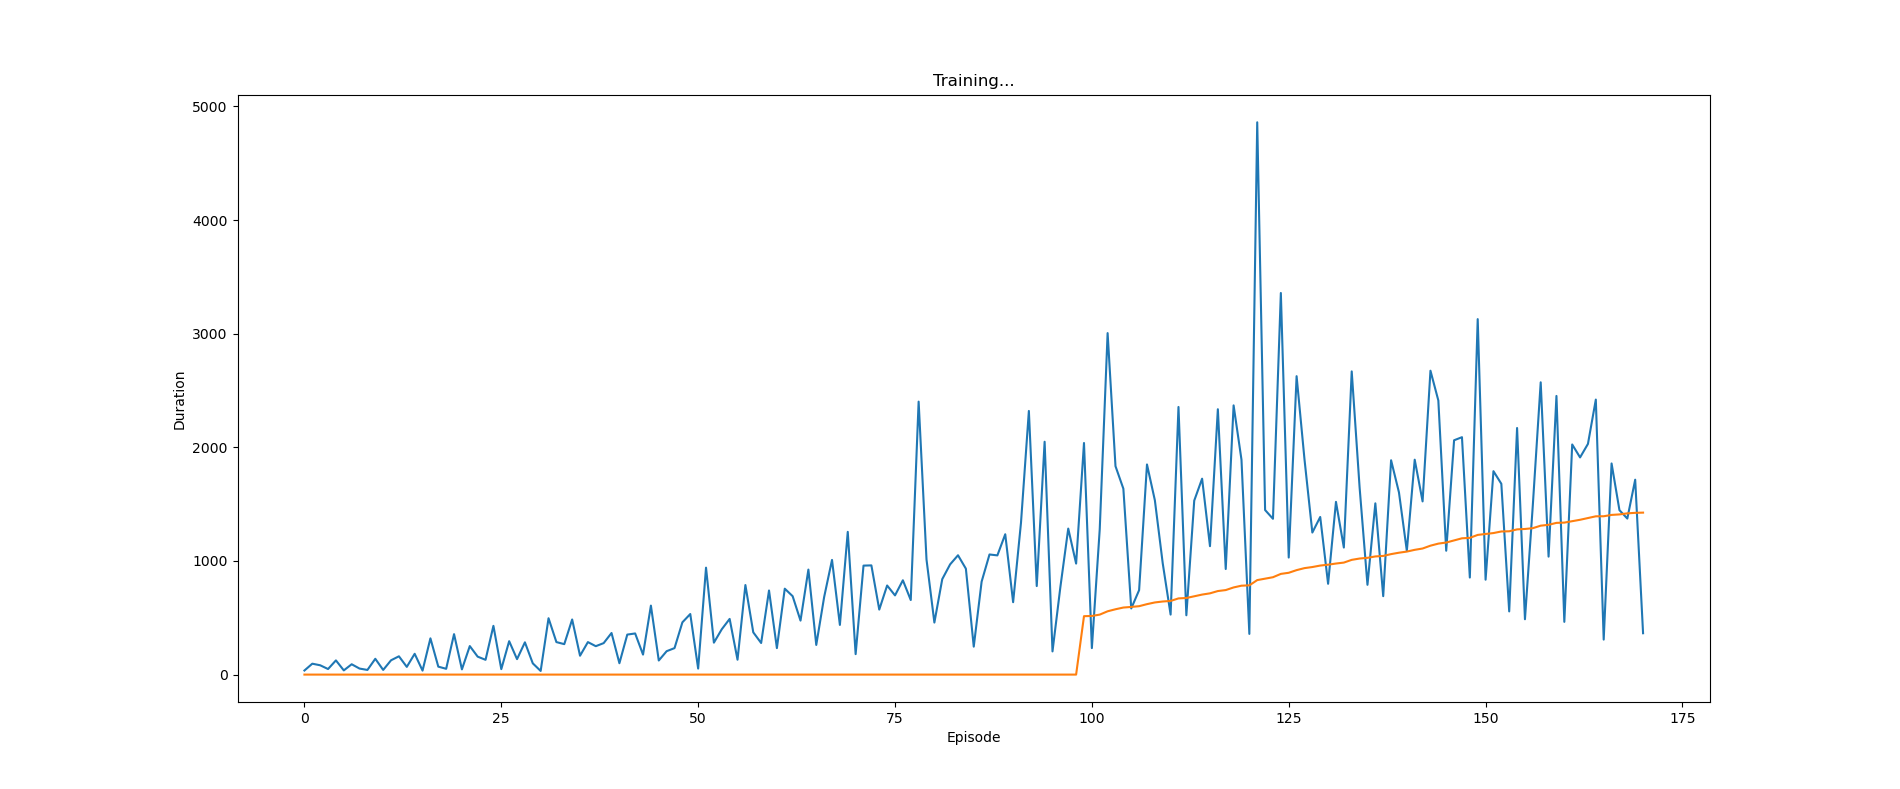

In [13]:
dqn_tracker.plot_returns(returns, show_result=False)
dqn_tracker.plot_durations(durations, show_result=False)

Text(0.5, 1.0, 'loss')

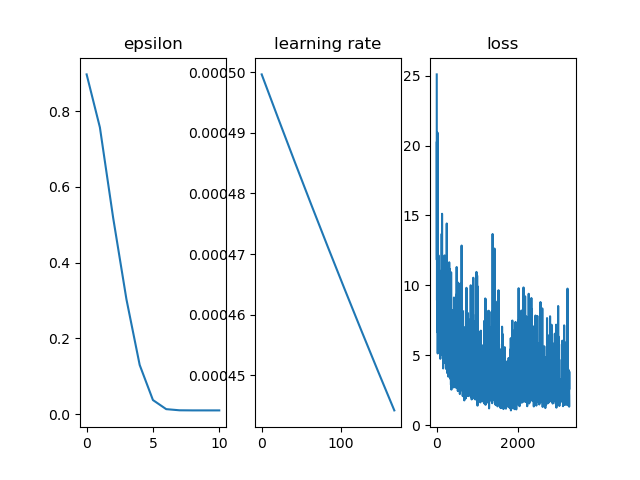

In [14]:
fig, ax = plt.subplots(1,3)
ax[0].plot(eps)
ax[0].set_title("epsilon")
ax[1].plot(lr, label="lr")
ax[1].set_title("learning rate")
ax[2].plot(loss, label="loss")
ax[2].set_title("loss")

In [ ]:
fname = '/home/brysongray/tractography/outputs/bundle_density_ep1.pt'
density = torch.load(fname)
print(density.shape)

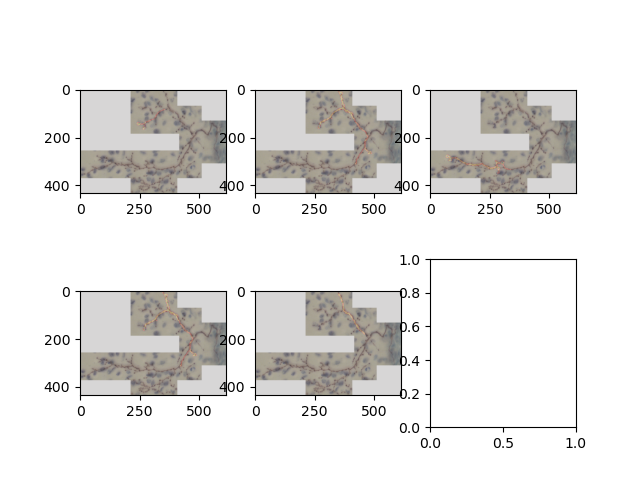

In [15]:
plt.close('all')
fig, ax = plt.subplots(2,3)
for r in range(2):
    for c in range(3):
        i = (r+1)*(c+1)
        if i == 6:
            break
        fname = f'/home/brysongray/tractography/outputs/bundle_density_ep{i-1}.pt'
        density = torch.load(fname)
        D = density.amax(dim=0)
        I = env.img.data[:3].amin(dim=(1))
        ax[r][c].imshow(D, cmap='hot', alpha=0.4)
        ax[r][c].imshow(I.permute(1,2,0), alpha=0.6)

# T = env.true_density.data.amax(dim=(0,1))
# plt.imshow(T, cmap='gray', alpha=0.5)


# Inference

In [ ]:
f = open('/home/brysongray/tractography/neuron_trx/configs/config.json')
args = json.load(f)

img_file = args["image"]
label_file = args["label"]
seeds = args["seeds"]
model = args["model"] if "model" in args else None
n_seeds = args["n_seeds"] if "n_seeds" in args else 1
step_size = args["step_size"] if "step_size" in args else 1.0
step_width = args["step_width"] if "step_width" in args else 1.0
batch_size = args["batchsize"] if "batchsize" in args else 128
gamma = args["gamma"] if "gamma" in args else 0.99
eps_start = args["eps_start"] if "eps_start" in args else 0.9
eps_end = args["eps_end"] if "eps_end" in args else 0.01
eps_decay = args["eps_decay"] if "eps_decay" in args else 1000
tau = args["tau"] if "tau" in args else 0.001
lr = args["lr"] if "lr" in args else 5e-4
alpha = args["alpha"] if "alpha" in args else 1.0
beta = args["beta"] if "beta" in args else 1e-3
friction = args["friction"] if "friction" in args else 1e-4
num_episodes = args["num_episodes"] if "num_episodes" in args else 100
pixelsize = args["pixelsize"] if "pixelsize" in args else [1.0, 1.0, 1.0]
patch_radius = 17
actions = np.load('/home/brysongray/tractography/neuron_trx/action_space_30_dir.npy')

img, density, mask = load_data(img_file, label_file, downsample_factor=10, binary=False)

env = Environment(img,
                    patch_radius,
                    seeds,
                    mask,
                    density,
                    actions,
                    n_seeds=1,
                    step_size=step_size,
                    step_width=step_width,
                    pixelsize=pixelsize,
                    max_len=10000,
                    alpha=alpha,
                    beta=beta,
                    friction=friction)

model = DQNModel(4, n_actions=len(actions), input_size=(2*patch_radius+1))
params = torch.load("/home/brysongray/tractography/outputs/model_state_dict_config_alpha-1_beta-0_f-0.pt")

model.load_model(params)


In [ ]:
plt.figure()
plt.imshow(env.true_density.data[0,19])

In [ ]:
seeds = [[19,325,201]]
env.seeds = seeds
env = model.inference(env)

In [ ]:
env.step_size

In [ ]:
p = env.get_state()[1]
v = (p[1] - p[0]) /env.step_size
w = (p[2] - p[1]) / env.step_size
a = torch.dot(v,w)
print(v)
print(w)
print(a)

In [ ]:
plt.figure()
D = env.img.data[-1].amax(dim=(0))
T = env.true_density.data.amax(dim=(0,1))
I = env.img.data[:3].amin(dim=(1))
plt.imshow(D, cmap='hot', alpha=0.5)
# plt.imshow(I.permute(1,2,0), alpha=0.5)
plt.imshow(T, cmap='gray', alpha=0.5)